In [1]:
%%HTML
<script src="require.js"></script>

In [2]:
from IPython.display import display, HTML, clear_output
HTML('''
<script src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js "></script><script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
} else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);</script><form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')

<img src='title_cover.png'/>

<h2 style='color:#35A1F4'>Problem</h2>

Sentiment Analysis, often referred to as Opinion Mining, stands as a pertinent and impactful application within the realms of Machine Learning and Natural Language Processing. Its utility spans across a diverse array of applications, encompassing employee feedback assessments, e-commerce customer reviews analysis, and market research endeavors.

Building on our foundational understanding of classification models in Machine Learning 1, today we embark on an exploration of the nuanced methodologies employed for sentiment classification. <b>We will delve into both traditional machine learning approaches and the utilization of TextBlob, a dedicated Natural Language Processing (NLP) library. Throughout this exploration, we will evaluate the merits and drawbacks of each technique, providing a comprehensive understanding of their respective strengths and limitations.</b>

<h2 style='color:#35A1F4'>Highlights</h2>

1. To compare, data was preprocessed similarly, and Naive Bayes used for both TextBlob and Traditional ML.
2. Both models surpass the Proportion Chance Criterion (0.41), showcasing high accuracy.
3. Traditional ML (0.69 accuracy) slightly outperforms TextBlob (0.66 accuracy) and provides more descriptive features (words).
4. TextBlob simplifies text classification with ease and quick implementation.
5. Custom models offer greater flexibility, control, and visibility for text classification.

<h2 style='color:#35A1F4'>Libraries and Functions</h2>

<h3 style='color:#8F76F9'>Import Library</h3>

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import spacy
import warnings

from warnings import simplefilter

from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import make_classification
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

<h3 style='color:#8F76F9'>Functions</h3>

<p>The following functions were defined:</p>
<ul>
    <li><b>compute_pcc</b> for computing the Proportion Chance Criterion (PCC) and 1.25 * PCC from a dataframe</li>
    <li><b>determine_sentiment</b> for getting the Sentiment (3 for positive, 2 for neutral, 1 for negative) from the Rating and Recommended IND columns.</li>
    <li><b>lemmatize text</b> for turning text into their base form.</li>
</ul>

In [4]:
def compute_pcc(df):
    """
    Compute the Proportion Chance Criterion (PCC) and 1.25 * PCC based on
    grouped sentiment counts.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing a 'Sentiment' column with categorical labels.

    Returns
    -------
    None
        The function prints the Proportion Chance Criterion (PCC) and 1.25*PCC.
    """
    grouped_sentiment = df.groupby('Sentiment').size()
    num = (grouped_sentiment/grouped_sentiment.sum())**2
    ppc = 100*num.sum()
    ppc_125 = ppc * 1.25
    print(f'Proportion Chance Criterion: {ppc:.2f}')
    print(f'1.25 * Proportion Chance Criterion: {ppc_125:.2f}')

In [5]:
def determine_sentiment(row):
    """
    Determine sentiment based on rating and recommendation.

    Parameters
    ----------
    row : pandas.Series
        A pandas Series representing a row of a DataFrame with 'Rating' and 'Recommended IND' columns.

    Returns
    -------
    int
        An integer representing the sentiment:
        - 3 for positive sentiment (Rating > 3 and Recommended IND == 1)
        - 1 for negative sentiment (Rating < 3 and Recommended IND == 0)
        - 2 for neutral sentiment (otherwise)
    """
    if row['Rating'] > 3 and row['Recommended IND'] == 1:
        return 3
    elif row['Rating'] < 3 and row['Recommended IND'] == 0:
        return 1
    else:
        return 2

In [6]:
nlp = spacy.load("en_core_web_sm")

def lemmatize_text(text):
    """
    Lemmatize the input text using spaCy.

    Parameters
    ----------
    text : str
        The input text to be lemmatized.

    Returns
    -------
    str
        The lemmatized text.
    """
    return ' '.join([token.lemma_ for token in nlp(text)])

<h2 style='color:#35A1F4'>Dataset</h2>

<h3 style='color:#8E77F8'>Data Source and Description</h3>

<p>This data from <a href="https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews">Kaggle</a> centers around customer feedback for a <i>Women's Clothing E-Commerce</i> company. References to the company in the review text and body have been replaced with the term "retailer" for privacy and anonymity.

The data holds 23,486 reviews with 10 original features. Each row corresponds to a customer review and features include:
    <ul>
    <li>`Clothing ID`: Integer Categorical variable that refers to the specific piece being reviewed.</li>
    <li>`Age`: Positive Integer variable of the reviewers age.</li>
    <li>`Title`: String variable for the title of the review.</li>
    <li>`Review Text`: String variable for the review body.</li>
    <li>`Rating`: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.</li>
    <li>`Recommended IND`: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not</li> recommended.
    <li>`Positive Feedback Count`: Positive Integer documenting the number of other customers who found this review positive.</li>
    <li>`Division Name`: Categorical name of the product high level division.</li>
    <li>`Department Name`: Categorical name of the product department name.</li>
    <li>`Class Name`: Categorical name of the product class name.</li>
    </ul>



<b>A look into the original data gives us:</b>

In [7]:
raw_df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
raw_df.drop(raw_df.columns[0], axis=1, inplace = True)
raw_df.head(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


<center><i>Table 1. Original reviews dataset<i></center>

<h2 style='color:#35A1F4'>Methodology and Implementation</h2>

In this study, we will use both traditional machine learning methods and TextBlob to classify customer reviews. To gain an apples-to-apples comparison of the results of the classification of using traditional method and that of TextBlob, we use similar preprocessing methods for both instances. Here is a summary of the methodology:

<img src='method.png'/>

<center><i>Table 2. Methodology and Pipeline<i></center>

<h3 style='color:#8E77F8'>Add a new feature `Sentiment`</h3>

<p>A new categorical feature "Sentiment" was added. This will be used as the target variable. Reviews with a rating of 4 to 5 and is recommended by the customer will be Positive reviews (encoded as 3). Reviews with a rating of 1 to 2 and is NOT recommended by the customer will be Negative reviews (encoded as 1). All other reviews will be Neutral (encoded as 2).</p>

In [8]:
raw_df['Sentiment'] = raw_df.apply(determine_sentiment, axis=1)
raw_df.head(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Sentiment
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,3
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,3
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,2


<center><i>Table 3. Reviews data with added feature "Sentiment"<i></center>

<h3 style='color:#8E77F8'>Remove null reviews</h3>

For this study, the predictor variable that will be used is the `Review Text` feature, therefore, all rows with null `Review Text` will be removed.

In [9]:
raw_df.isnull().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
Sentiment                     0
dtype: int64

In [10]:
raw_df = raw_df.dropna(subset=['Review Text'])

In [11]:
raw_df.isnull().sum()

Clothing ID                   0
Age                           0
Title                      2966
Review Text                   0
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                13
Department Name              13
Class Name                   13
Sentiment                     0
dtype: int64

<h3 style='color:#8E77F8'>Data Exploration</h3>

The data was explored to see the any trends from the reviews dataset.

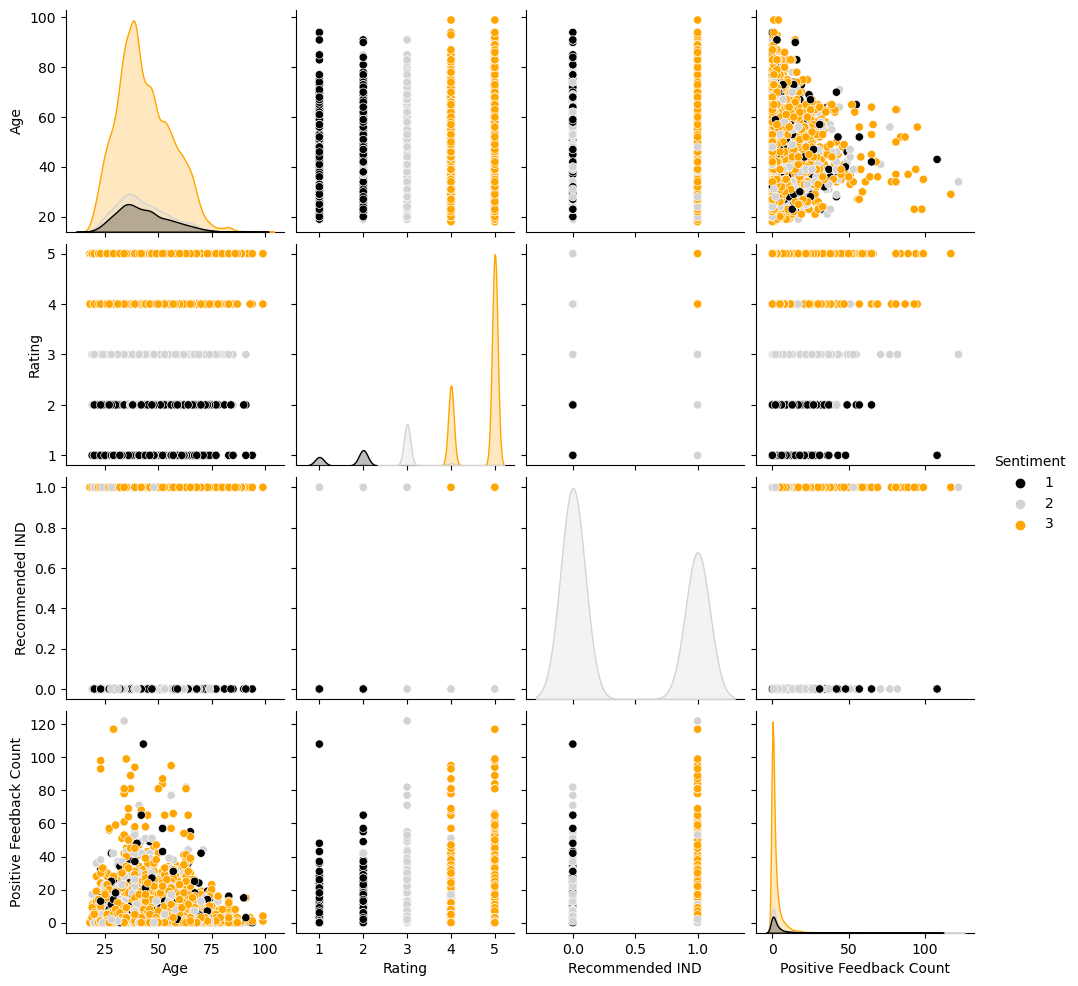

In [12]:
df_onlynum = raw_df[['Age', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Sentiment']]
sentiment_colors = {3:'orange', 1:'black', 2:'lightgray'}
sns.pairplot(df_onlynum, hue='Sentiment', palette=sentiment_colors, diag_kind='kde')

<center><i>Fig. 1. Pairplot of numerical variables from the Reviews<i></center>

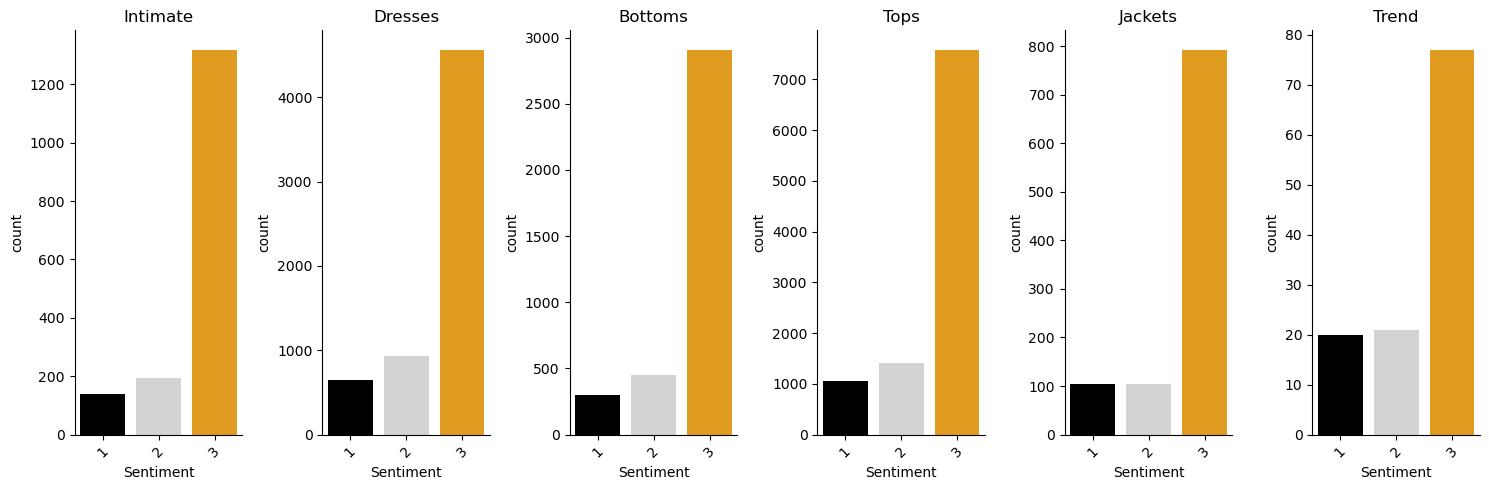

In [13]:
departments = raw_df['Department Name'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(departments)-1, figsize=(15, 5))

for i, department in enumerate(departments):
    department_df = raw_df[raw_df['Department Name'] == department]
    if not department_df['Sentiment'].empty:
        sns.countplot(x='Sentiment', data=department_df, palette=sentiment_colors, ax=axes[i])
        axes[i].set_title(f'{department}')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Rotate x-axis labels
        sns.despine(ax=axes[i])

plt.tight_layout()
plt.show()

<center><i>Fig. 2. Comparitive bar graphs of the sentiment counts per Depertment<i></center>

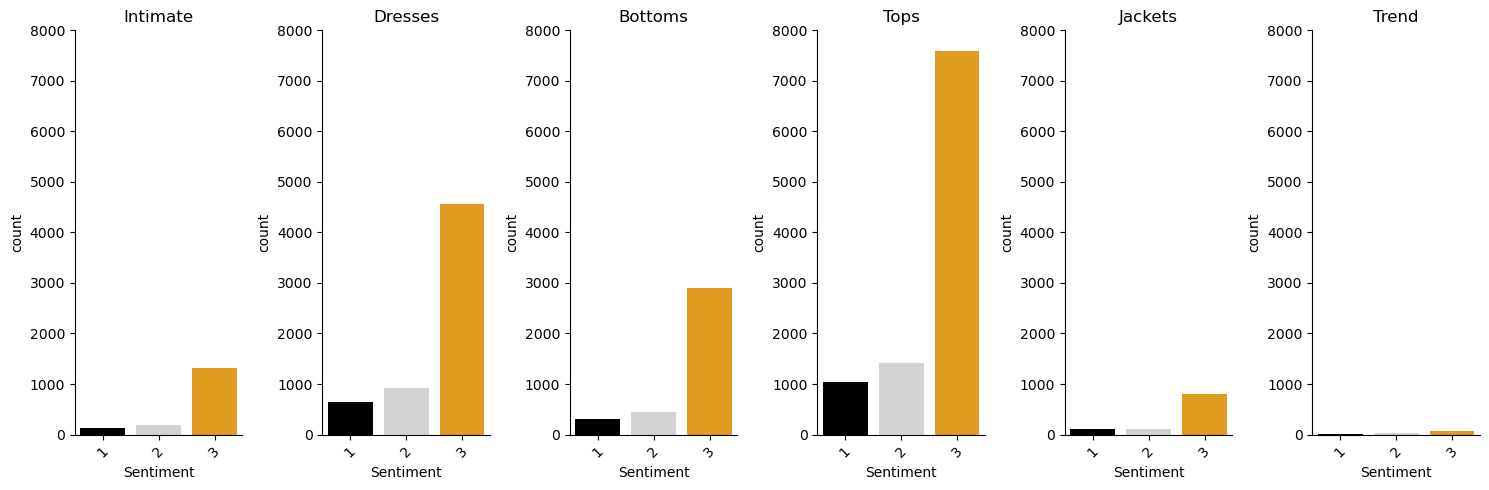

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=len(departments)-1, figsize=(15, 5))
max_count = raw_df.groupby('Sentiment').size().max()

for i, department in enumerate(departments):
    department_df = raw_df[raw_df['Department Name'] == department]
    if not department_df['Sentiment'].empty:
        sns.countplot(x='Sentiment', data=department_df, palette=sentiment_colors, ax=axes[i])
        axes[i].set_title(f'{department}')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Rotate x-axis labels
        axes[i].set_ylim(0, 8000)  # Set the y-axis limit
        sns.despine(ax=axes[i])

plt.tight_layout()
plt.show()

<center><i>Fig. 3. Comparitive bar graphs of the sentiment counts per Depertment, with the same scale<i></center>

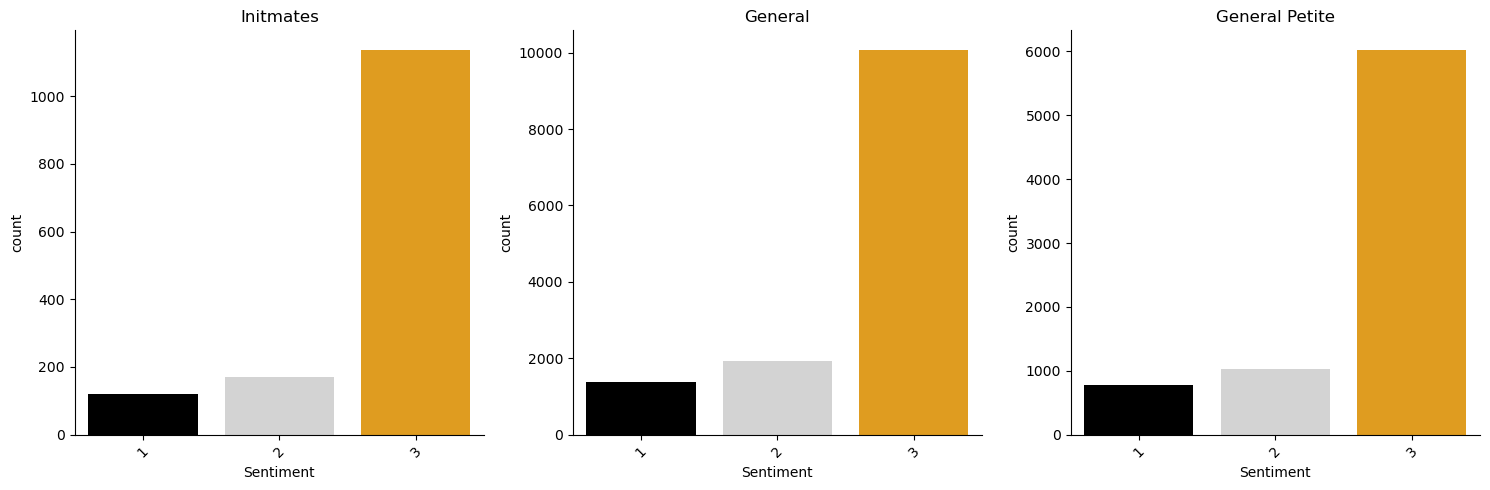

In [15]:
divisions = raw_df['Division Name'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(divisions)-1, figsize=(15, 5))

for i, division in enumerate(divisions):
    department_df = raw_df[raw_df['Division Name'] == division]
    if not department_df['Sentiment'].empty:
        sns.countplot(x='Sentiment', data=department_df, palette=sentiment_colors, ax=axes[i])
        axes[i].set_title(f'{division}')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Rotate x-axis labels
        sns.despine(ax=axes[i])

plt.tight_layout()
plt.show()

<center><i>Fig. 4. Comparitive bar graphs of the sentiment counts per Division<i></center>

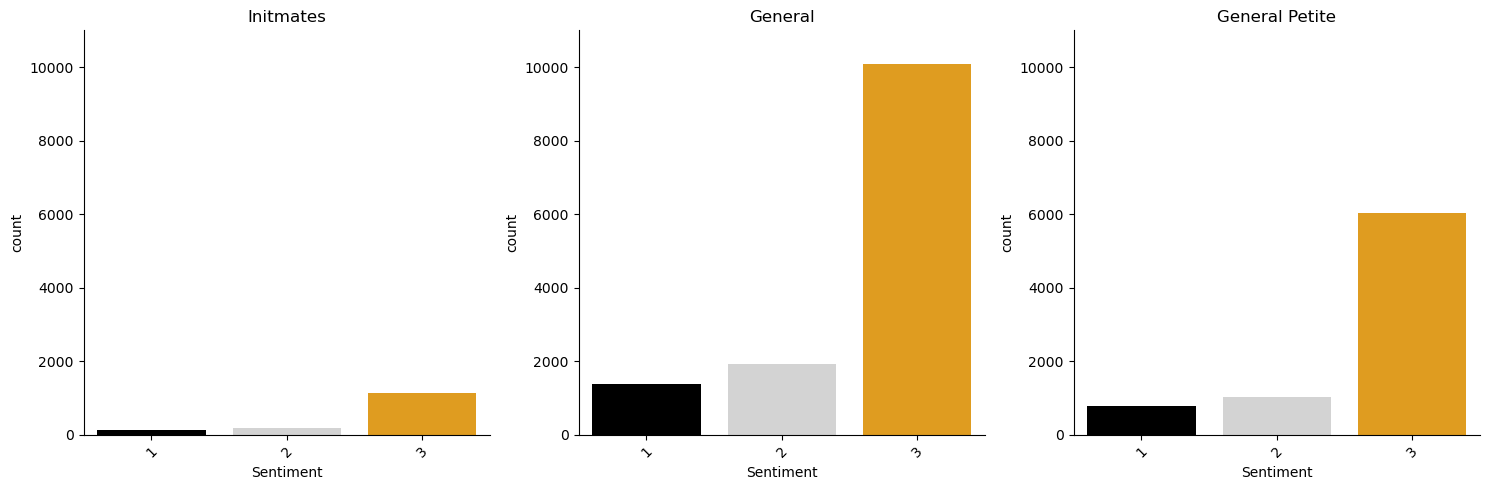

In [16]:
divisions = raw_df['Division Name'].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(divisions)-1, figsize=(15, 5))

for i, division in enumerate(divisions):
    department_df = raw_df[raw_df['Division Name'] == division]
    if not department_df['Sentiment'].empty:
        sns.countplot(x='Sentiment', data=department_df, palette=sentiment_colors, ax=axes[i])
        axes[i].set_title(f'{division}')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)  # Rotate x-axis labels
        axes[i].set_ylim(0, 11000)
        sns.despine(ax=axes[i])

plt.tight_layout()
plt.show()

<center><i>Fig. 5. Comparitive bar graphs of the sentiment counts per Division, with the same scale<i></center>

<h4 style='color:#3AB85C'>Data Exploration Discussion</h3>

From the graphs above, we see that different reviews (positive, negative, neutral) were given by all customers regardless of age. We also see a comparitively high number of positive reviews, compared to neutral and negative reviews. This is the case for all Departments, and even for all Divisions. The top 3 departments are the Tops, Dresses, and Bottoms, in order, giving them more reviews than other departments.

<h3 style='color:#8E77F8'>Split the dataset</h3>

The dataset was split into the train-validation (80%) and test (20%) sets.

<h4 style='color:#3AB85C'>Use only `Review Text` and `Sentiment` features.</h3>

In [40]:
senti_df = raw_df[['Review Text', 'Sentiment']]
print(f'Dataframe of reviews with only Text and Sentiment columns has {senti_df.shape} shape')

Dataframe of reviews with only Text and Sentiment columns has (22641, 2) shape


<h4 style='color:#3AB85C'>Split to 20% test set</h4>

In [18]:
X = senti_df.drop('Sentiment', axis=1)
y = senti_df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

print(f'Training set contains: {len(X_train)} rows')
print(f'Test set contains: {len(X_test)} rows')

Training set contains: 18112 rows
Test set contains: 4529 rows


<h3 style='color:#8E77F8'>Lemmatize the reviews</h3>

To optimize the performance of the custom trained model, the train `Review Text` was lemmatized, turning words into their base form.

In [19]:
X_train['Review Text'] = X_train['Review Text'].apply(lemmatize_text)

<h3 style='color:#8E77F8'>Undersample</h3>

The training data was imbalanced with a majority of 76% positive reviews. To remove unintentional bias from the model, the training data was resampled using the Random Undersampler from Imblearn.

<h4 style='color:#3AB85C'>Sentiment Distribution</h4>

In [20]:
senti_counts = senti_df['Sentiment'].value_counts()
total_senti = len(senti_df['Sentiment'])
senti_100 = senti_counts / total_senti * 100

senti_ct = pd.DataFrame({
    'Sentiment': senti_counts.index,
    'Count': senti_counts.values,
    'Percentage': senti_100.values.round(2)
})

senti_ct

,Sentiment,Count,Percentage
0,3,17261,76.24
1,2,3119,13.78
2,1,2261,9.99


<center><i>Table 4. Original distribution of sentiments<i></center>

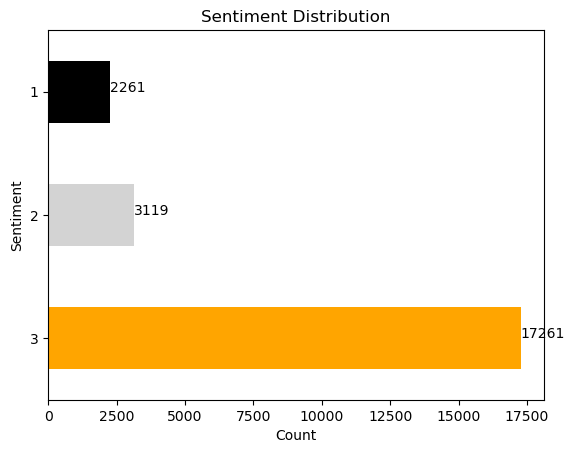

In [21]:
ax = senti_counts.plot(kind='barh', color=['orange', 'lightgrey', 'black'])

for index, value in enumerate(senti_counts):
    ax.text(value, index, str(value))

plt.title('Sentiment Distribution')
plt.xlabel('Count')
plt.ylabel('Sentiment')
plt.show()

<center><i>Fig. 6. Sentiment distribution bar graph<i></center>

<h4 style='color:#3AB85C'>Random Undersampling</h4>

For computational efficiency, random undersampling was utilized, equalizing the distribution of positive, neutral and negative reviews.

In [22]:
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X_train, y_train)

class_counts_before = pd.Series(y_train).value_counts()
class_counts_after = pd.Series(y_resampled).value_counts()

print("Before Undersampling:")
print(class_counts_before, '\n')
compute_pcc(senti_df)
print('-'*20)
print("\nAfter Undersampling:")
print(class_counts_after, '\n')
compute_pcc(y_resampled.to_frame())

Before Undersampling:
Sentiment
3    13806
2     2474
1     1832
Name: count, dtype: int64 

Proportion Chance Criterion: 61.02
1.25 * Proportion Chance Criterion: 76.27
--------------------

After Undersampling:
Sentiment
1    1832
2    1832
3    1832
Name: count, dtype: int64 

Proportion Chance Criterion: 33.33
1.25 * Proportion Chance Criterion: 41.67


<h3 style='color:#8E77F8'>Count Vectorizer</h3>

The text in the `Review Text` was vectorized to enable processing. English stop words were used to remove common words. Only words considered were those in atleast 5 documents, and at most at 80% of the documents to remove the "noise" (words) from the data. Only words considered were alphabetic characters with atleast 2 letters.

In [24]:
countvec = CountVectorizer(
    stop_words='english',
    token_pattern=r'\b[a-z]{2,}\b',
    lowercase=True,
    min_df=5,
    max_df=.8
)

X_resampled_countvec = countvec.fit_transform(X_resampled['Review Text'])
X_test_countvec = countvec.transform(X_test['Review Text'])

feature_names = countvec.get_feature_names_out()
print(f'Number of features (words): {len(feature_names)}')

Number of features (words): 1810


<h3 style='color:#8E77F8'>Grid Search</h3>

GridSearch was used to find the best model and best parameter to use. Different classifiers were tried including Logistic Regession, Linear Support Vector Machine, K Neighbors Classifer, Random Forest Classifier, Gradient Boosting Classifer, and Multinomial Naive Bayes.

In [25]:
C_range = [1.e-05, 1.e-03, 1.e-01, 1.e+01, 1.e+03, 1.e+05]
alpha_range = [1.e-05, 1.e-03, 1.e-01, 1.0, 1.e+01, 1.e+03, 1.e+05]
max_depth_range = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
learning_rate_range = [0.1, 0.5, 1.0]
n_neighbor_range = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

pipe = Pipeline([('clf', None)])

param_grid = [
    {'clf': [LogisticRegression()],
     'clf__penalty': ['l1', 'l2'],
     'clf__C': C_range, 
     'clf__solver': ['liblinear']},

    {'clf': [LinearSVC()], 
     'clf__penalty': ['l1', 'l2'],
     'clf__C': C_range, 
     'clf__dual': [False]},

    {'clf': [KNeighborsClassifier()],
     'clf__n_neighbors': n_neighbor_range},

    {'clf': [RandomForestClassifier()],
     'clf__max_depth': max_depth_range},

    {'clf': [GradientBoostingClassifier()],
     'clf__learning_rate': learning_rate_range,
     'clf__max_depth': max_depth_range},

    {'clf': [MultinomialNB()],
     'clf__alpha': alpha_range,
    }
]

grid_search = GridSearchCV(pipe, param_grid, cv=5, return_train_score=True,
                           scoring='accuracy', verbose=3, error_score='raise')
grid_search.fit(X_resampled_countvec, y_resampled)

Fitting 5 folds for each of 85 candidates, totalling 425 fits
[CV 1/5] END clf=LogisticRegression(), clf__C=1e-05, clf__penalty=l1, clf__solver=liblinear;, score=(train=0.167, test=1.000) total time=   0.0s
[CV 2/5] END clf=LogisticRegression(), clf__C=1e-05, clf__penalty=l1, clf__solver=liblinear;, score=(train=0.250, test=0.666) total time=   0.0s
[CV 3/5] END clf=LogisticRegression(), clf__C=1e-05, clf__penalty=l1, clf__solver=liblinear;, score=(train=0.417, test=0.000) total time=   0.0s
[CV 4/5] END clf=LogisticRegression(), clf__C=1e-05, clf__penalty=l1, clf__solver=liblinear;, score=(train=0.417, test=0.000) total time=   0.0s
[CV 5/5] END clf=LogisticRegression(), clf__C=1e-05, clf__penalty=l1, clf__solver=liblinear;, score=(train=0.417, test=0.000) total time=   0.0s
[CV 1/5] END clf=LogisticRegression(), clf__C=1e-05, clf__penalty=l2, clf__solver=liblinear;, score=(train=0.614, test=0.000) total time=   0.0s
[CV 2/5] END clf=LogisticRegression(), clf__C=1e-05, clf__penalty=l2

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('clf', None)]),
             param_grid=[{'clf': [LogisticRegression()],
                          'clf__C': [1e-05, 0.001, 0.1, 10.0, 1000.0, 100000.0],
                          'clf__penalty': ['l1', 'l2'],
                          'clf__solver': ['liblinear']},
                         {'clf': [LinearSVC()],
                          'clf__C': [1e-05, 0.001, 0.1, 10.0, 1000.0, 100000.0],
                          'clf__dual': [False], 'clf__penalty': ['l1', 'l2']},
                         {'clf': [...
                          'clf__n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
                         {'clf': [RandomForestClassifier()],
                          'clf__max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                             15]},
                         {'clf': [GradientBoostingClassifier()],
                          'clf__learning_rate': [0.1, 0.5, 1.0],
                          'clf__max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                                             15]},
                         {'clf': [MultinomialNB()],
                          'clf__alpha': [1e-05, 0.001, 0.1, 1.0, 10.0, 1000.0,
                                         100000.0]}],
             return_train_score=True, scoring='accuracy', verbose=3)

<h4 style='color:#3AB85C'>Best Scores per Model</h4>

In [26]:
grid_df = pd.DataFrame(grid_search.cv_results_)
grid_df['param_clf'] = grid_df['param_clf'].astype(str)
per_model = grid_df.loc[grid_df.groupby('param_clf')['rank_test_score'].idxmin()]

per_model[
    ['param_clf', 'rank_test_score', 'mean_test_score', 'mean_train_score',
     'mean_fit_time', 'mean_score_time']
].sort_values(by='rank_test_score')

,param_clf,rank_test_score,mean_test_score,mean_train_score,mean_fit_time,mean_score_time
81,MultinomialNB(),1,0.471457,0.766831,0.002994,0.001374
7,LogisticRegression(),4,0.423049,0.929494,0.395127,0.001513
19,LinearSVC(),5,0.420681,0.962382,2.630117,0.001585
67,GradientBoostingClassifier(),18,0.370294,0.989083,5.158388,0.009540
24,KNeighborsClassifier(),54,0.302572,1.000000,0.003242,0.250982
44,RandomForestClassifier(),68,0.144859,0.778975,0.606247,0.035438


<center><i>Table 5. Best scores per model via Grid Search results<i></center>

<h4 style='color:#3AB85C'>Best Model to Use</h4>

In [27]:
print(f"The best model is: {grid_search.best_params_}")
print(f"with an accuracy score of: {grid_search.best_score_}")

The best model is: {'clf': MultinomialNB(), 'clf__alpha': 1.0}
with an accuracy score of: 0.47145719248903967


<h3 style='color:#8E77F8'>Train and Test: Multinomial Naive Bayes</h3>

The resulting best model from GridSearch was the Multinomial Naive Bayes model with alpha=1. This was used to train and test the dataset.

<h4 style='color:#3AB85C'>Fit</h4>

In [28]:
reg = MultinomialNB(alpha=1)
reg.fit(X_resampled_countvec, y_resampled)

MultinomialNB(alpha=1)

<h4 style='color:#3AB85C'>Score</h4>

In [29]:
reg_train_score = reg.score(X_resampled_countvec, y_resampled)
reg_test_score = reg.score(X_test_countvec, y_test)

print(f'Train Score: {reg_train_score}')
print(f'Test Score: {reg_test_score}')

Train Score: 0.738901018922853
Test Score: 0.6992713623316406


<h4 style='color:#3AB85C'>Top 10 Features</h4>

In [32]:
log_probabilities = reg.feature_log_prob_
n_top_features = 10

# Concatenate feature names with corresponding classes
all_features = np.concatenate(
    [feature_names[np.argsort(log_probabilities[i])[::-1][:n_top_features]] \
     for i in range(log_probabilities.shape[0])])

all_labels = np.concatenate([
    ['Negative'] * n_top_features,
    ['Neutral'] * n_top_features,
    ['Positive'] * n_top_features
])

# Get the unique top 10 features
unique_top_features, indices = np.unique(all_features, return_index=True)
top_10_features = unique_top_features[:n_top_features]
top_10_labels = all_labels[indices][:n_top_features]

reg_top_features = pd.DataFrame({
    'Top Feature': top_10_features,
    'Sentiment': top_10_labels
})
reg_top_features

,Top Feature,Sentiment
0,color,Neutral
1,dress,Negative
2,fabric,Negative
3,fit,Negative
4,great,Positive
5,just,Negative
6,like,Negative
7,look,Negative
8,love,Negative
9,size,Negative


<center><i>Table 6. Top 10 features for Traditional ML<i></center>

<h3 style='color:#8E77F8'>Train and Test: TextBlob Naive Bayes</h3>

From the TextBlob library the NaiveBayes Classifier is called to train, and then to test the dataset. Because TextBlob only looks for a list of tuples of the text and the target variable, the only data passed to the classifier is the resampled dataset (eg. "Absolutely wonderful - silky and sexy and comfortable" - "positive"), and not the vectorized dataset.

<h4 style='color:#3AB85C'>Fit</h4>

In [33]:
train_df = pd.concat([X_resampled, y_resampled], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# the datasets are turned into a list of tuples
train = [(row['Review Text'], row['Sentiment']) \
         for index, row in train_df.iterrows()]
test = [(row['Review Text'], row['Sentiment']) \
        for index, row in test_df.iterrows()]

# call the classifier
tb = NaiveBayesClassifier(train)

<h4 style='color:#3AB85C'>Score</h4>

In [34]:
tb_train_score = tb.accuracy(train)
tb_test_score = tb.accuracy(test)

print(f'Train Score: {tb_train_score}')
print(f'Test Score: {tb_test_score}')

Train Score: 0.8089519650655022
Test Score: 0.6637226760874365


<h4 style='color:#3AB85C'>Top 10 Features</h4>

In [35]:
tb.show_informative_features(10)

Most Informative Features
         contains(awful) = True                1 : 3      =     31.0 : 1.0
      contains(horrible) = True                1 : 3      =     17.7 : 1.0
         contains(shame) = True                1 : 3      =     17.0 : 1.0
        contains(flimsy) = True                1 : 3      =     16.3 : 1.0
        contains(highly) = True                3 : 1      =     15.8 : 1.0
      contains(occasion) = True                3 : 1      =     15.7 : 1.0
          contains(mess) = True                1 : 3      =     15.0 : 1.0
  contains(unflattering) = True                1 : 3      =     14.6 : 1.0
       contains(justice) = True                3 : 1      =     14.3 : 1.0
     contains(literally) = True                1 : 3      =     14.3 : 1.0


<center><i>Fig. 7. Top 10 features for TextBlob<i></center>

<h2 style='color:#35A1F4'>Results and Discussion</h2>

To measure the performance of each of the models, and to gain an apples-to-apples comparison, the accuracy score of each model is compared. We also output the top 10 features (words) from each model for comparison.

<h3 style='color:#8E77F8'>Model Scores Comparison</h3>

<h4 style='color:#3AB85C'>Train and Test Scores for Traditional ML and TextBlob Classifier</h4>

In [36]:
data = {
    'Type': ['Traditional ML', 'TextBlob'],
    'Specific Model': ['Multinomial Naive Bayes', 'Naive Bayes Classifier'],
    'Train Score': [reg_train_score, tb_train_score],
    'Test Score': [reg_test_score, tb_test_score]
}

# Creating a DataFrame
df_scores = pd.DataFrame(data)

df_scores

,Type,Specific Model,Train Score,Test Score
0,Traditional ML,Multinomial Naive Bayes,0.738901,0.699271
1,TextBlob,Naive Bayes Classifier,0.808952,0.663723


<center><i>Table 7. Comparitive Scores for Traditional ML and TextBlob<i></center>

<h3 style='color:#8E77F8'>Top 10 Features Comparison</h3>

<h4 style='color:#3AB85C'>Top Features from Traditional ML - Multinomial Naive Bayes</h4>

In [37]:
reg_top_features

,Top Feature,Sentiment
0,color,Neutral
1,dress,Negative
2,fabric,Negative
3,fit,Negative
4,great,Positive
5,just,Negative
6,like,Negative
7,look,Negative
8,love,Negative
9,size,Negative


<center><i>Table 6. Top 10 features for Traditional ML<i></center>

<h4 style='color:#3AB85C'>Top Features from TextBlob - Naive Bayes Classifier</h4>

In [38]:
tb.show_informative_features(10)

Most Informative Features
         contains(awful) = True                1 : 3      =     31.0 : 1.0
      contains(horrible) = True                1 : 3      =     17.7 : 1.0
         contains(shame) = True                1 : 3      =     17.0 : 1.0
        contains(flimsy) = True                1 : 3      =     16.3 : 1.0
        contains(highly) = True                3 : 1      =     15.8 : 1.0
      contains(occasion) = True                3 : 1      =     15.7 : 1.0
          contains(mess) = True                1 : 3      =     15.0 : 1.0
  contains(unflattering) = True                1 : 3      =     14.6 : 1.0
       contains(justice) = True                3 : 1      =     14.3 : 1.0
     contains(literally) = True                1 : 3      =     14.3 : 1.0


<center><i>Fig. 7. Top 10 features for TextBlob<i></center>

<h3 style='color:#8E77F8'>Discussion</h3>

<h4 style='color:#3AB85C'>Recap on the Process</h4>

With the traditional Machine Learning method and with TextBlob, the dataset was treated the same. In preprocessing, the rows with null `Review Text` were removed (1), the data was split into 80% trainval and 20% test sets (2), and the training data was resampled using Random Undersampling (3).

For the Traditional ML methodology, the reviews text were lemmatized and vectorized using Spacy's lemmatization feature and Count Vectorizer respectively. Different classification models were used in GridSearch to find the best model, resulting to Multinomial Naive Bayes being the best model. The Multinomial Naive Bayes was used to train and test the dataset.

On the other hand, TextBlob offers an easy call to their classifiers, which allows us to train and test the model to our own dataset. The Naive Bayes classifier from the library was used to train and test the dataset.

<h4 style='color:#3AB85C'>Results Comparison and Pros and Cons</h4>

TextBlob Classifier is easily accessible and user-friendly, requiring no parameter tuning for quick deployment. However, this simplicity comes at the cost of limited visibility into tuning parameters and no direct access to individual top features when called.

In contrast, Traditional ML involves a more intricate process, with multiple steps required before identifying and utilizing the best model.

In both instances, the Naive Bayes model served as the basis for comparison. Renowned for its efficacy in text classification, Naive Bayes excels in multi-classification tasks, often outperforming alternative models (Ray, 2023).

Utilizing Multinomial Naive Bayes from SKLearn, Traditional ML achieved a superior test accuracy compared to TextBlob's Naive Bayes Classifier. This disparity may stem from custom preprocessing steps employed independently, diverging from the constraints of the TextBlob library. Unlike TextBlob, the library lacks customization options and parameter hyper-tuning capabilities.

Upon examining the top features of both methods, TextBlob predominantly yields adjectives. While these words distinctly convey sentiment, such as 'flimsy,' 'shame,' and 'unflattering' signaling negativity, they offer limited additional insights to stakeholders. The challenge lies in comprehending the underlying reasons behind the sentiment, as adjectives alone may not provide sufficient context or specific actionable points for improvement.

Conversely, Traditional ML's top words encompass both adjectives and nouns. Notably, negative reviews feature terms like 'dress,' 'fit,' and 'size.' This signals a need for alterations in garment fit and size, especially for dresses. Surprisingly, positive terms like 'like' and 'love' emerge as top features for negative reviews, warranting deeper investigation into the context and nuances of such occurrences.

<h2 style='color:#35A1F4'>Conclusion and Recommendations</h2>

<h3 style='color:#8E77F8'>Conclusion</h3>

Although leveraging libraries like TextBlob provides convenient access to text classification methods, it comes at the cost of reduced visibility and customization compared to a bespoke model.

Both models exhibit high accuracy and surpass the Proportion Chance Criterion, with Multinomial Naive Bayes achieving slightly superior accuracy compared to TextBlob.

TextBlob serves as an excellent choice for rapid implementation of text classification tasks, offering simplicity and ease of use. On the other hand, a custom model is ideal for situations demanding meticulous customization and seamless integration into a workflow, particularly when specific preprocessing of the data is required.

<h3 style='color:#8E77F8'>Recommendations</h3>

For individuals with a keen interest in Natural Language Processing (NLP), we highly recommend exploring and experimenting with the diverse functionalities offered by TextBlob. The versatility of TextBlob makes it an excellent tool for tasks such as sentiment analysis, part-of-speech tagging, and more.

Furthermore, we suggest considering the creation of a custom text classification model for those seeking greater flexibility and control, particularly in scenarios where specific requirements need to be addressed on a case-by-case basis. Custom models allow for the implementation of various preprocessing settings and methods, providing an opportunity for optimization based on specific needs. We encourage individuals to explore and experiment with different preprocessing approaches, as this can significantly impact the performance and effectiveness of a custom NLP model.

<h2 style='color:#35A1F4'>References</h2>

Loria, S. (2013). TextBlob Documentation. TextBlob. Retrieved December 9, 2023 from https://textblob.readthedocs.io/en/dev/index.html

Nicapotato. (2017). Women's E-Commerce Clothing Reviews. Retrieved December 9, 2023 from https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews

Ray, S. (2023, December 1). Naive Bayes Classifier Explained: Applications and Practice Problems of Naive Bayes Classifier. Analytics Vidhya. Retrieved December 9, 2023 from https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/

Note: ChatGPT was used to generate code, and paraphrase the thoughts of the author.